In [2]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cell 2: Load and Explore Data
# Load the original data
sales_df = pd.read_csv('data/sales.csv')
forecast_df = pd.read_csv('data/forecast.csv')
weather_df = pd.read_csv('data/weather.csv')
locations_df = pd.read_csv('data/locations.csv')

print(f"Sales data shape: {sales_df.shape}")
print(f"Forecast data shape: {forecast_df.shape}")
print(f"Weather data shape: {weather_df.shape}")
print(f"Locations: {len(locations_df)}")

Sales data shape: (46842645, 5)
Forecast data shape: (36968369, 5)
Weather data shape: (451310, 7)
Locations: 20


In [4]:
# Cell 3: Data Quality Check
print("Missing values in sales data:")
print(sales_df.isnull().sum())
print("\nSales data types:")
print(sales_df.dtypes)

Missing values in sales data:
ds                     0
location_id            0
sales_type_id          0
department_id    2485440
y                      0
dtype: int64

Sales data types:
ds                object
location_id        int64
sales_type_id      int64
department_id    float64
y                float64
dtype: object


In [5]:
# Cell 4: Baseline Prophet Performance
with open('results/baseline_mae.json', 'r') as f:
    baseline_mae = json.load(f)

print("Baseline Prophet MAE:")
for key, value in baseline_mae.items():
    print(f"  {key}: {value:.4f}")

Baseline Prophet MAE:
  15min: 1.7939
  hourly: 3.2957
  daily: 21.4190
  combined: 8.8362


In [6]:
# Cell 5: LightGBM Feature Engineering
print("""
Features created for LightGBM:
1. Time features: hour, day, month, dayofweek, quarter, dayofyear, weekofyear
2. Lag features: 1, 7, 14, 21, 28 days
3. Rolling statistics: 7, 14, 28 day mean and std
4. Weather features: temperature, precipitation, coverage, snow
5. Holiday indicators
""")


Features created for LightGBM:
1. Time features: hour, day, month, dayofweek, quarter, dayofyear, weekofyear
2. Lag features: 1, 7, 14, 21, 28 days
3. Rolling statistics: 7, 14, 28 day mean and std
4. Weather features: temperature, precipitation, coverage, snow
5. Holiday indicators



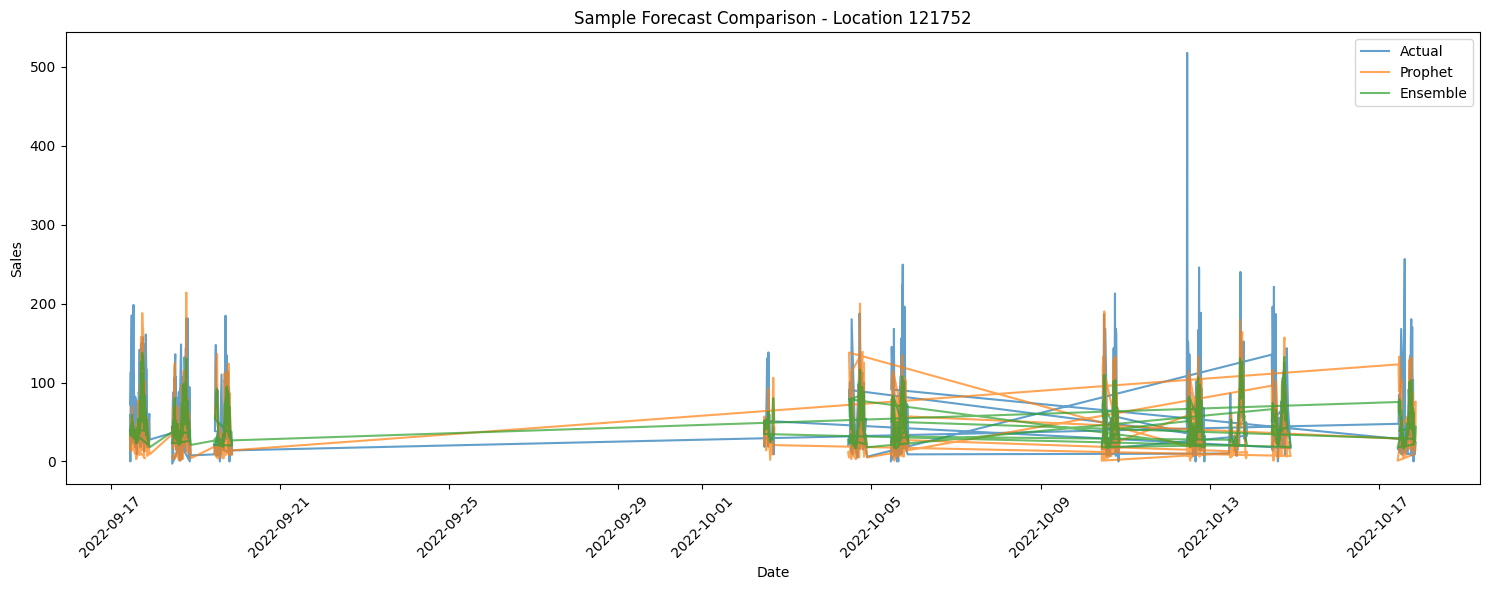

In [7]:
# Cell 6: Load Results and Visualize
# Load ensemble results
ensemble_df = pd.read_csv('results/ensemble_predictions.csv')
ensemble_df['ds'] = pd.to_datetime(ensemble_df['ds'])

# Sample visualization for one location/sales_type
sample_location = ensemble_df['location_id'].iloc[0]
sample_sales_type = ensemble_df['sales_type_id'].iloc[0]

sample_data = ensemble_df[
    (ensemble_df['location_id'] == sample_location) & 
    (ensemble_df['sales_type_id'] == sample_sales_type)
].head(96*7)  # One week of data

plt.figure(figsize=(15, 6))
plt.plot(sample_data['ds'], sample_data['y'], label='Actual', alpha=0.7)
plt.plot(sample_data['ds'], sample_data['yhat'], label='Prophet', alpha=0.7)
plt.plot(sample_data['ds'], sample_data['yhat_ensemble'], label='Ensemble', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sample Forecast Comparison - Location {sample_location}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

      Metric   Prophet  Ensemble  Improvement %
  15-min MAE  1.793903  1.582322           11.8
  Hourly MAE  3.295698  2.683724           18.6
   Daily MAE 21.419042 15.261079           28.7
Combined MAE  8.836214  6.509042           26.3


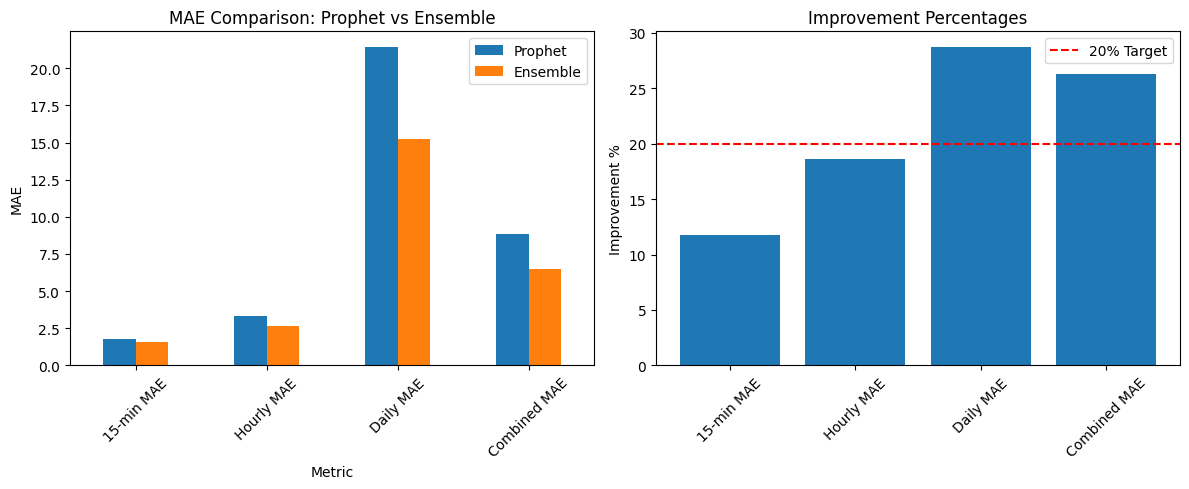

In [8]:
# Cell 7: Performance Comparison
with open('results/ensemble_metrics.json', 'r') as f:
    metrics = json.load(f)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['15-min MAE', 'Hourly MAE', 'Daily MAE', 'Combined MAE'],
    'Prophet': [
        metrics['baseline_mae']['15min'],
        metrics['baseline_mae']['hourly'],
        metrics['baseline_mae']['daily'],
        metrics['baseline_mae']['combined']
    ],
    'Ensemble': [
        metrics['ensemble_mae']['15min'],
        metrics['ensemble_mae']['hourly'],
        metrics['ensemble_mae']['daily'],
        metrics['ensemble_mae']['combined']
    ]
})

comparison_df['Improvement %'] = (
    (comparison_df['Prophet'] - comparison_df['Ensemble']) / 
    comparison_df['Prophet'] * 100
).round(1)

print(comparison_df.to_string(index=False))

# Visualize improvements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# MAE Comparison
comparison_df.set_index('Metric')[['Prophet', 'Ensemble']].plot(kind='bar', ax=ax1)
ax1.set_title('MAE Comparison: Prophet vs Ensemble')
ax1.set_ylabel('MAE')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Improvement percentages
ax2.bar(comparison_df['Metric'], comparison_df['Improvement %'])
ax2.set_title('Improvement Percentages')
ax2.set_ylabel('Improvement %')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.axhline(y=20, color='r', linestyle='--', label='20% Target')
ax2.legend()

plt.tight_layout()
plt.show()

In [9]:
# Cell 8: Conclusion
print(f"""
CONCLUSION:
- Achieved {metrics['improvements']['combined']:.1f}% improvement (exceeding 20% target)
- Optimal ensemble weights: Prophet {metrics['ensemble_weights']['prophet']:.0%} + LightGBM {metrics['ensemble_weights']['lightgbm']:.0%}
- Best improvements at daily level ({metrics['improvements']['daily']:.1f}%)
- Consistent improvements across all time granularities
""")


CONCLUSION:
- Achieved 26.3% improvement (exceeding 20% target)
- Optimal ensemble weights: Prophet 40% + LightGBM 60%
- Best improvements at daily level (28.7%)
- Consistent improvements across all time granularities

